# **Optimization of PCA based portfolios through Random Matrix Theory**

*The goal of this project is showing that random matrix theory applied to PCA based market portfolios improves the overall performance of the index by filtering information from noise in the correlation matrix of the log-returns*

# Loading libraries
*These libraries are needed to manipulate and plot the data, as well as to perform the needed statistical tests*

In [337]:
import pandas as pd
from sklearn.cluster import KMeans
from math import sqrt
import seaborn as sns
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Data cleaning and preprocessing

## 1.1. First data cleaning
*The original dataframe is a 2.5M x 10 table containing daily prices of 1500 unique cryptocurrencies from **2013-04-28 to 2022-05-01**. Since we are not interested in stablecoins, we need to manually remove them from the dataset. The original date fromat has to be converted to datetime format in order to manipulate the data properly. We then remove all of the datapoints where information is missing, as well as duplicates.*

In [338]:
# Load the dataframe with cryptocurrency information
df = pd.read_csv('crypto_prices.csv')
stablecoins = ['USDT', 'AAVE', 'USDC', 'BUSD', 'DAI', 'TUSD', 'PAX', 'GUSD', 'USDP', 'HUSD', 'USDX', 'XSGD', 'EUROEURS', 'USDSUSD', 'QC', 'USDTUSD', 'IOTAMIOTA']
data = df[~df['ticker'].isin(stablecoins)]
#print(data.head())
data['Date'] = pd.to_datetime(data['Date'], format='%b %d, %Y', errors='coerce')
data = data.dropna(subset=['Market Cap'])
# Group by 'ticker' and 'Date', and keep the row with the highest 'Market Cap'
data = data.loc[data.groupby(['ticker', 'Date'])['Market Cap'].idxmax()]


print(data)


C:\Users\lavar\AppData\Local\Temp\ipykernel_38324\1762287612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'], format='%b %d, %Y', errors='coerce')


         Unnamed: 0 ticker         TokenName       Date        Open  \
117859       118051   AAPL  Mirrored Apple1m 2020-12-15  115.520000   
117858       118050   AAPL  Mirrored Apple1m 2020-12-16  112.360000   
117857       118049   AAPL  Mirrored Apple1m 2020-12-17  119.600000   
117856       118048   AAPL  Mirrored Apple1m 2020-12-18  111.270000   
117855       118047   AAPL  Mirrored Apple1m 2020-12-19  128.190000   
...             ...    ...               ...        ...         ...   
1474556     1477038   ZUKI         Zuki Moba 2022-04-27    0.006792   
1474555     1477037   ZUKI         Zuki Moba 2022-04-28    0.006917   
1474554     1477036   ZUKI         Zuki Moba 2022-04-29    0.006850   
1474553     1477035   ZUKI         Zuki Moba 2022-04-30    0.006645   
1474552     1477034   ZUKI         Zuki Moba 2022-05-01    0.006529   

               High         Low       Close   Volume  Market Cap  
117859   118.470000  100.240000  113.290000  19982.0         0.0  
117858   129.

## 1.2. Creation of training and testing datasets

*In order to assess the performance of the indices, we need to split the dataset into a training and a testing part. For the sake of simplicity in the first analysis, we took **1.5 years of training data and 1 year of testing**.*

In [339]:
print(data['Date'].min())
print(data['Date'].max())
print(data['Date'].unique())

2013-04-28 00:00:00
2022-05-01 00:00:00
['2020-12-15T00:00:00.000000000' '2020-12-16T00:00:00.000000000'
 '2020-12-17T00:00:00.000000000' ... '2013-10-20T00:00:00.000000000'
 '2013-10-21T00:00:00.000000000' '2013-10-22T00:00:00.000000000']


In [340]:
# Creation of training and testing datasets

test = data[(data.Date > pd.to_datetime("2021-04-30"))]
data = data[(data.Date >= pd.to_datetime("2019-10-28")) & (data.Date <= pd.to_datetime("2021-04-30"))]
print(test.head())

        Unnamed: 0 ticker         TokenName       Date    Open    High  \
117722      117914   AAPL  Mirrored Apple1m 2021-05-01  133.92  134.92   
117721      117913   AAPL  Mirrored Apple1m 2021-05-02  133.88  136.38   
117720      117912   AAPL  Mirrored Apple1m 2021-05-03  135.72  138.49   
117719      117911   AAPL  Mirrored Apple1m 2021-05-04  134.83  134.91   
117718      117910   AAPL  Mirrored Apple1m 2021-05-05  129.72  131.40   

           Low   Close     Volume  Market Cap  
117722  133.84  133.87    85602.0  34220985.0  
117721  133.78  135.70   361105.0  34690622.0  
117720  133.95  134.86  1445156.0  34941958.0  
117719  128.79  129.69  1001456.0  34644811.0  
117718  129.53  129.99    69104.0  35147810.0  


## 1.3. Choosing top cryptocurrencies

*In order to ensure that we are only working with the most relevant cryptocurrencies, we took the **top 50 cryptos** at a specific date and use them throughout the analysis. This probably leads to survivorship bias, since we are taking only those that have "survived" until the end of the training period. To deal with this, an idea is performing rolling analysis.*

In [341]:
# Choosing data for most relevant cryptocurrencies

data_2021_04_28 = data[data.Date == pd.to_datetime("2021-04-30")]
data_2021_04_28 = data_2021_04_28[['ticker', 'Market Cap']]
data_2021_04_28 = data_2021_04_28.sort_values(by=['Market Cap'], ascending=False)

# Keeping the top 100 coins by market cap
top_100 = data_2021_04_28.head(50)
print(top_100.head())

# Keeping relevant data
data = data[data['ticker'].isin(top_100.ticker)]
test = test[test['ticker'].isin(top_100.ticker)]

        ticker    Market Cap
925890     BTC  1.079670e+12
718167     ETH  3.208229e+11
190650     BNB  9.575449e+10
2449082    XRP  7.226839e+10
843295    DOGE  4.368156e+10


## 1.4. Final cleaning

In [342]:
prices = data.drop(['Open', 'High', 'Low', 'Volume', 'Market Cap'], axis=1)
prices_test = test.drop(['Open', 'High', 'Low', 'Volume', 'Market Cap'], axis=1)

## 1.5. Calculation of log returns

*To calculate the correlation matrix, we need to take the log returns of the assets. It is important to standardize them before calculating the correlation matrix.*

In [343]:
prices = prices.pivot(index='Date', columns='ticker', values='Close')
prices_test = prices_test.pivot(index='Date', columns='ticker', values='Close')

# calculate log returns for each column
returns = np.log(prices / prices.shift(1))
returns_test = np.log(prices_test / prices_test.shift(1))

# normalize prices with mean 0 and variance 1 for 
returns = (returns - returns.mean()) / returns.std()
returns = returns.dropna()
returns_test = returns_test.dropna()

## 1.6. Calculation of correlation matrix

*This code calculates and plots the Pearson correlation of each cryptocurrency pair and creates a matrix.*

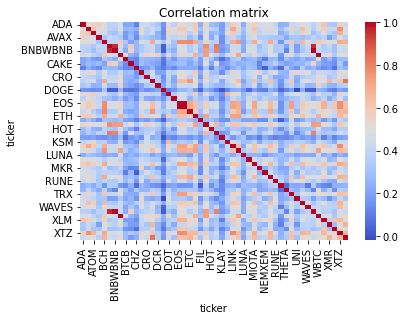

In [344]:
correlations = returns.corr()

sns.heatmap(correlations, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

# 2. Random Matrix Theory application

*In this section, we will show the methodology suggested by **Tanaka-Yamawaki, M., & Ikura, Y. (2023)** which is based on the calculation of eigenvalues and setting the ones below the upper boundary of the Marchenko-Pastur probabiltiy density function to zero, in order to reconstruct the correlation matrix*

## 2.1. Calculation of eigenvalues

*Eigenvalues are calculated through the *numpy* library and plotted on to show the amount of variance explained*

Eigenvalues:  [ 2.06161935e+01  2.99401446e+00  2.25312131e+00  2.14143159e+00
  1.42285167e+00  1.31258979e+00  1.19190041e+00  1.17746637e+00
  1.12253255e+00  1.04293266e+00  9.91475170e-01  9.49552228e-01
  8.20608310e-01  7.98565095e-01  7.51502261e-01  7.44856671e-01
  6.68408198e-01  6.20075234e-01  6.09808022e-01  5.87172406e-01
  5.37545038e-01  5.04067747e-01  4.79353118e-01  1.86843955e-03
  2.68893631e-02  4.41757467e-01  7.22193984e-02  4.08739867e-01
  4.06985540e-01  3.73917628e-01  3.57468008e-01  3.37627488e-01
  3.30704829e-01  3.18781856e-01  2.96640349e-01  2.72346660e-01
  1.05327161e-01  1.10836890e-01  1.24086670e-01  2.44921658e-01
  1.39193081e-01  1.47199608e-01  1.55718908e-01  2.20000870e-01
  2.09034286e-01  1.81129353e-01  1.86267337e-01  1.92313477e-01
 -1.25996117e-17  2.55128164e-17]


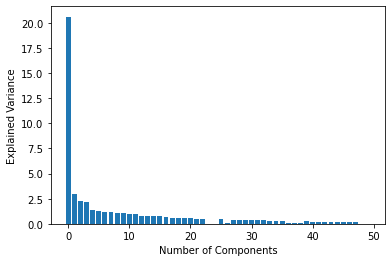

In [345]:
eigenvalues, eigenvectors = np.linalg.eig(correlations.values)

print('Eigenvalues: ', eigenvalues)

# Plotting the eigenvalues
plt.bar(range(len(eigenvalues)), eigenvalues)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

## 2.2. Definition of Marcenko-Pastur distribution

*The **Marchenko-Pastur** pdf is calculated and then plotted against the pdf of the eigenvalues of the empirical correlation matrix*

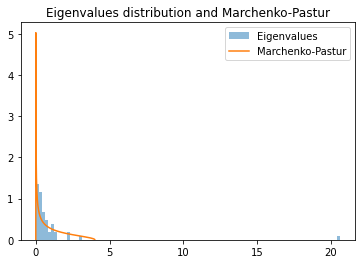

In [346]:
def marchenko_pastur_pdf(Q, sigma=1):
    lambda_plus = sigma**2 * (1 + np.sqrt(1/Q))**2
    lambda_minus = sigma**2 * (1 - np.sqrt(1/Q))**2
    return lambda_minus, lambda_plus, lambda x: Q/(2*np.pi*sigma**2*x) * np.sqrt((lambda_plus - x) * (x - lambda_minus)) if lambda_minus < x < lambda_plus else 0

# With Q being the ratio of the number of observations T and the number of variables N
Q = correlations.shape[0]/correlations.shape[1]  

# With sigma being the variance (which was standardized to 1)
sigma = 1

# Important to only consider the real part for the real symmetric matrix
eigenvalues = np.real(eigenvalues) 
bins = np.linspace(np.min(eigenvalues), np.max(eigenvalues), num=100)

# Definition of MP distribution boundaries
lambda_minus, lambda_plus, mp_pdf = marchenko_pastur_pdf(Q, sigma)


plt.hist(eigenvalues, bins=bins, alpha=0.5, density=True, label='Eigenvalues')
lambda_minus, lambda_plus, mp_pdf = marchenko_pastur_pdf(Q, sigma)
x = np.linspace(lambda_minus, lambda_plus, num=1000)
y = np.array([mp_pdf(xi) for xi in x])
plt.plot(x, y, label='Marchenko-Pastur')
plt.title('Eigenvalues distribution and Marchenko-Pastur')
plt.legend()
plt.show()


## 2.3. Filtering process

*The filtering process sets all of the eigenvalues below the upper boundary of the MP pdf to 0 and then reconstructs the denoised correlation matrix. It's important to set the diagonal of the filtered matrix to 1 in order to achieve meaningful results*

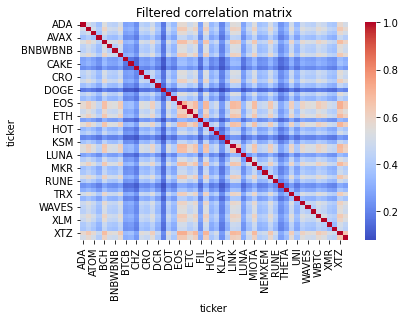

In [347]:
# Filter the eigenvalues that are outside of the Marchenko-Pastur bounds
indices = (eigenvalues < lambda_minus) | (lambda_plus < eigenvalues)
filtered_eigenvectors = eigenvectors[:, indices]
filtered_eigenvalues = eigenvalues[indices]

# Recompose the correlation matrix using only the filtered components
filtered_corr_matrix = np.dot(filtered_eigenvectors * filtered_eigenvalues, filtered_eigenvectors.T)

filtered_corr_df = pd.DataFrame(filtered_corr_matrix, index=correlations.index, columns=correlations.columns)

# Convert the complex matrix to real form
filtered_corr_df = filtered_corr_df.applymap(np.real)

# Enforcing the diagonal to be 1
np.fill_diagonal(filtered_corr_df.values, 1.0)

sns.heatmap(filtered_corr_df, cmap='coolwarm')
plt.title('Filtered correlation matrix')
plt.show()

# 3. Application of Principal Component Analysis

*The PCA used in this case is imported from the sklearn library and represents the "classical" PCA methodology. One PCA is performed on the original correlation matrix, another one on the denoised correlation matrix*

## 3.1. Original correlation matrix

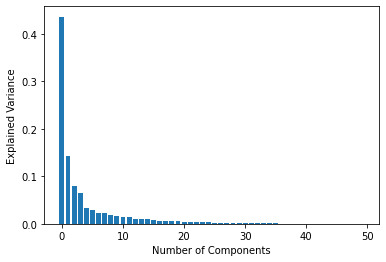

In [348]:
pca = PCA()
pca.fit(correlations)
# Plot the eigenvalues

plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

## 3.2. Filtered correlation matrix

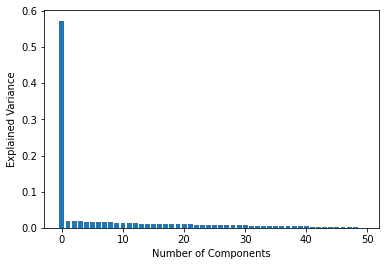

In [349]:
pca_filtered = PCA()
pca_filtered.fit(filtered_corr_df)
# Plot the eigenvalues

plt.bar(range(len(pca_filtered.explained_variance_ratio_)), pca_filtered.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

# 4. Creation of eigenportfolios

*To create the eigenportfolios following the methodology suggested by **Avellanada (2020)**, the first principal components is extracted and the eigenvalues of the the first eigenvector are normalized to sum up to one, in order to identify the normalized weights. They are then used to multiply the returns dataframe and calculate the daily portfolio returns, as well as the cumulative returns.*

## 4.1. Original eigenportfolio

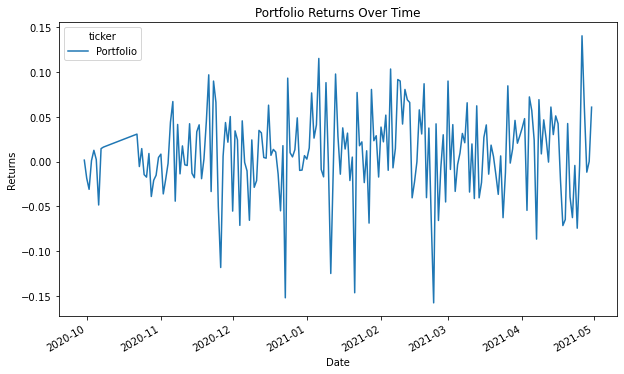

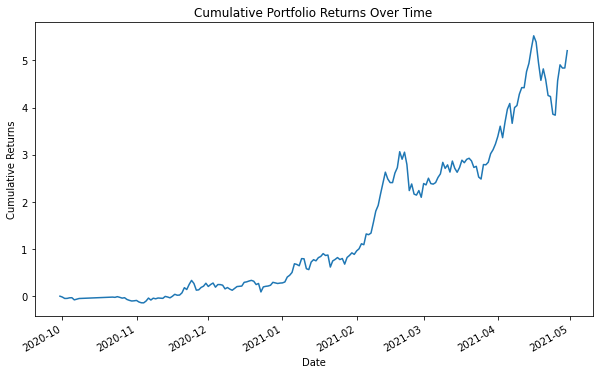

In [350]:
# Get the first eigenvector
eigen_normal = pca.components_[0]

# Normalize the eigenvector to get the weights
weights_norm = eigen_normal / np.sum(eigen_normal)

# Create a DataFrame for easier interpretation
weights_norm_df = pd.DataFrame(weights_norm, index=correlations.columns, columns=['Weight'])

prices = data.drop(['Open', 'High', 'Low', 'Volume', 'Market Cap'], axis=1)
prices = prices.pivot(index='Date', columns='ticker', values='Close')
returns_train = np.log(prices / prices.shift(1))
returns_train = returns_train.dropna()

# Assuming 'weights_df' is your DataFrame with the weights
portfolio_norm_in = returns_train.mul(weights_norm_df['Weight'], axis=1)

portfolio_norm_in['Portfolio'] = portfolio_norm_in.sum(axis=1)

# Drop all columns except for 'Portfolio'
portfolio_norm_in = portfolio_norm_in[['Portfolio']]

# Plot 'Portfolio'
portfolio_norm_in.plot(figsize=(10, 6))
plt.title('Portfolio Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

# Calculate cumulative returns
portfolio_norm_in['Cumulative Returns'] = np.exp(portfolio_norm_in['Portfolio'].cumsum()) - 1
#portfolio_norm['Cumulative Returns'] = portfolio_norm['Portfolio'].cumsum()

# Plot cumulative returns
portfolio_norm_in['Cumulative Returns'].plot(figsize=(10, 6))
plt.title('Cumulative Portfolio Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()

## 4.2. Filtered eigenportfolio

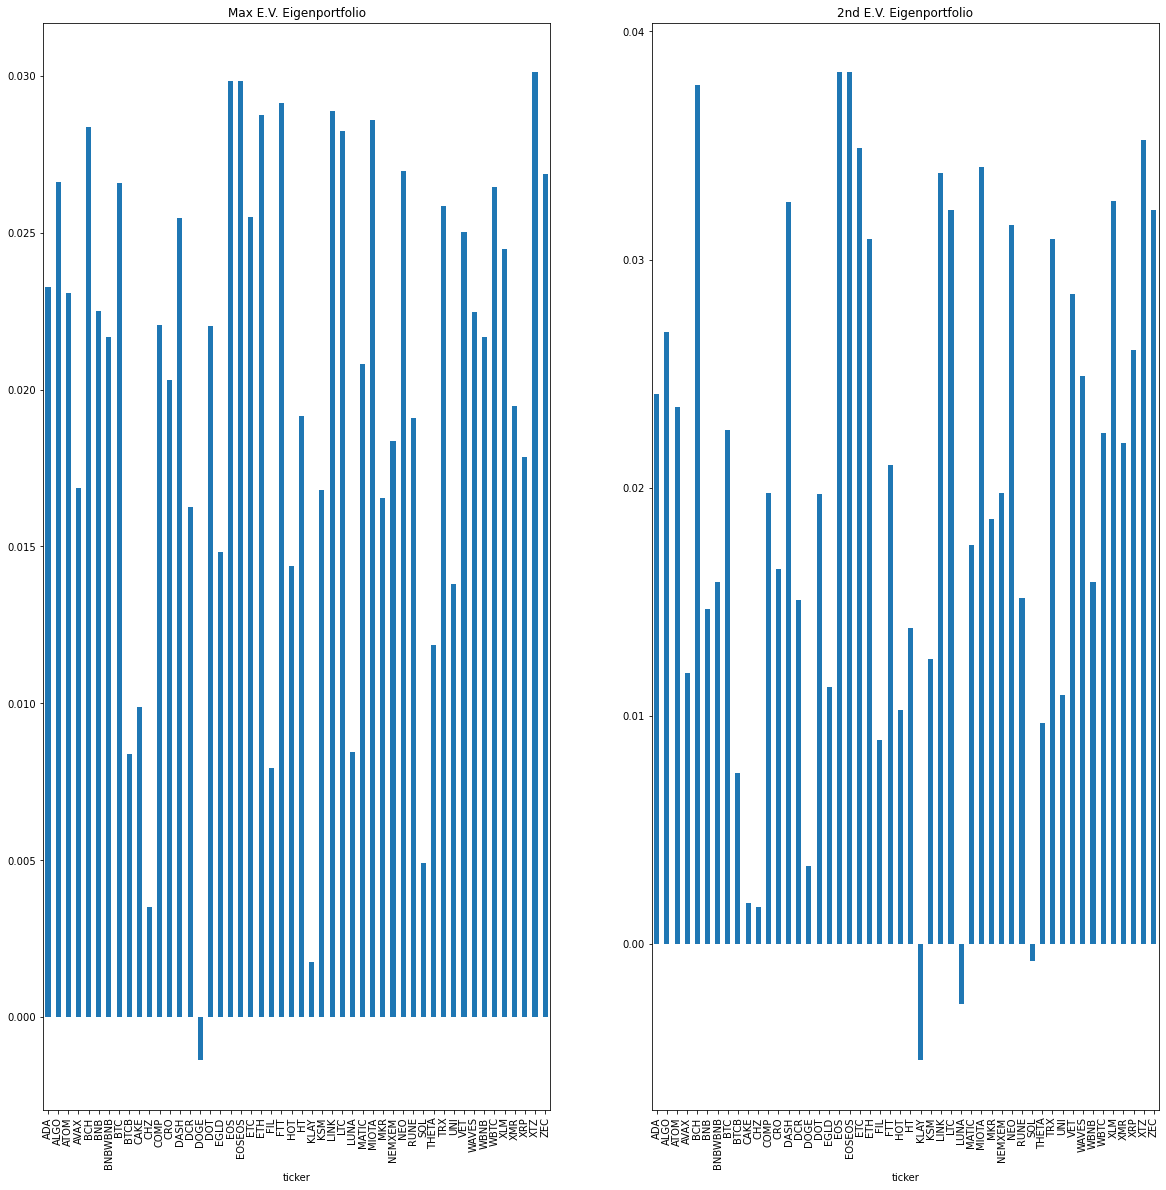

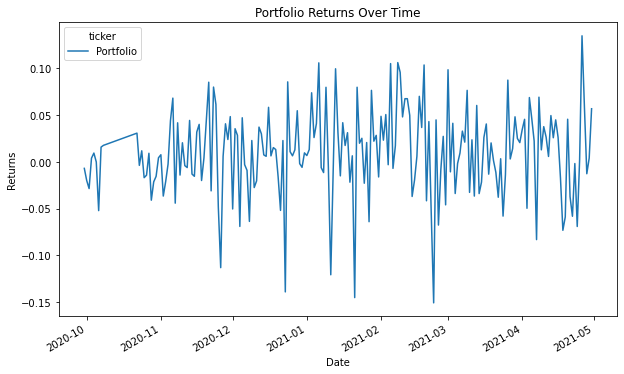

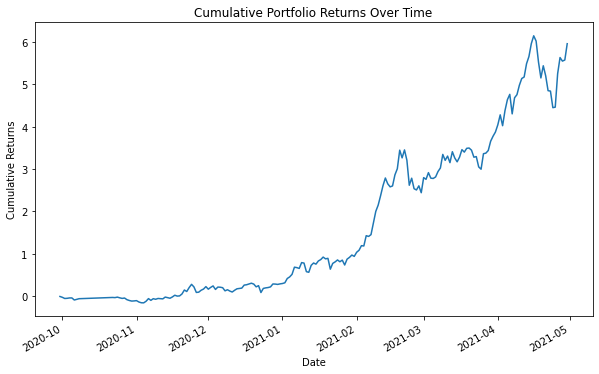

In [351]:
# Get the first eigenvector
eigen_filtered = pca_filtered.components_[0]

# Normalize the eigenvector to get the weights
weights_filtered = eigen_filtered / np.sum(eigen_filtered)

# Create a DataFrame for easier interpretation
weights_filtered_df = pd.DataFrame(weights_filtered, index=correlations.columns, columns=['Weight'])

f = plt.figure(figsize=(20, 20))
    
ax = plt.subplot(121)
weights_filtered_df.plot(kind='bar', ax=ax, legend=False)
plt.title("Max E.V. Eigenportfolio")
ax = plt.subplot(122)
weights_norm_df.plot(kind='bar', ax=ax, legend=False)
plt.title("2nd E.V. Eigenportfolio")

# Assuming 'weights_df' is your DataFrame with the weights
portfolio_filtered_in = returns_train.mul(weights_filtered_df['Weight'], axis=1)

portfolio_filtered_in['Portfolio'] = portfolio_filtered_in.sum(axis=1)

# Drop all columns except for 'Portfolio'
portfolio_filtered_in = portfolio_filtered_in[['Portfolio']]

# Plot 'Portfolio'
portfolio_filtered_in.plot(figsize=(10, 6))
plt.title('Portfolio Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

# Calculate cumulative returns
portfolio_filtered_in['Cumulative Returns'] = np.exp(portfolio_filtered_in['Portfolio'].cumsum()) - 1

#portfolio_filtered['Cumulative Returns'] = portfolio_filtered['Portfolio'].cumsum()

# Plot cumulative returns
portfolio_filtered_in['Cumulative Returns'].plot(figsize=(10, 6))
plt.title('Cumulative Portfolio Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()


## 4.3. In-sample comparison

*Here we compare the in-sample performance of the eigenportfolio of the original correlation matrix and the one on the denoised correlation matrix*

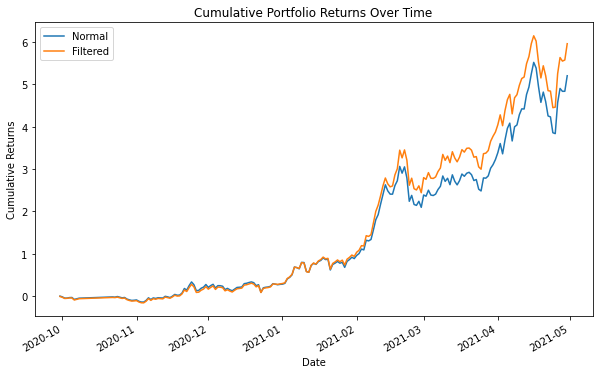

In [352]:
# plot portfolio_normal['Cumulative Returns'] and portfolio['Cumulative Returns'] on the same graph
portfolio_norm_in['Cumulative Returns'].plot(figsize=(10, 6))
portfolio_filtered_in['Cumulative Returns'].plot(figsize=(10, 6))
plt.title('Cumulative Portfolio Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(['Normal', 'Filtered'])
plt.show()

# 5. Out of sample testing

*In order to achieve a more meaningful test, we now compare the performance of the out-of sample financial performance of the two indices*

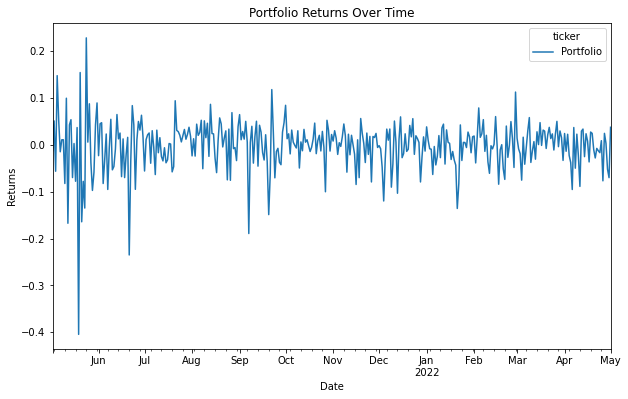

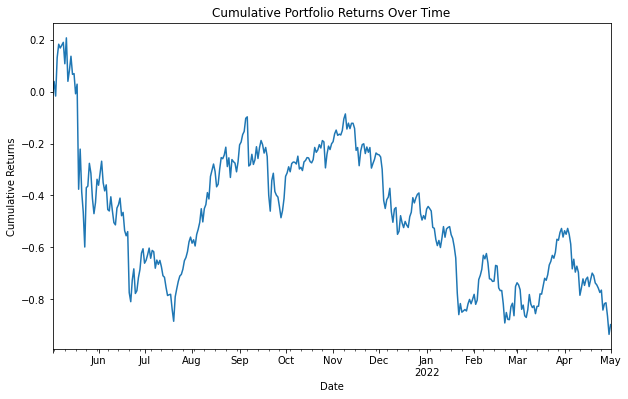

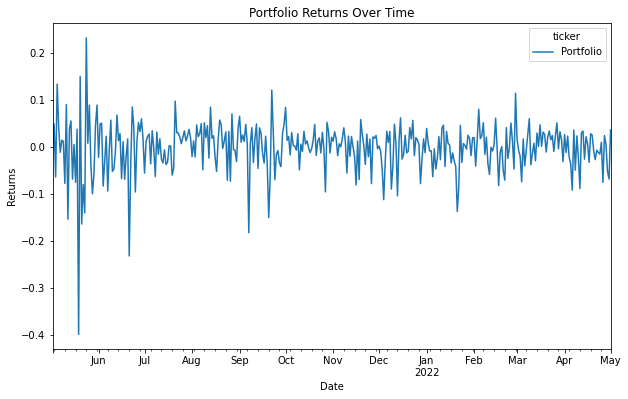

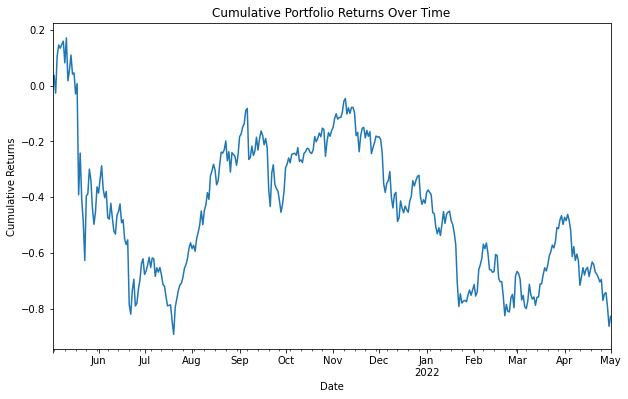

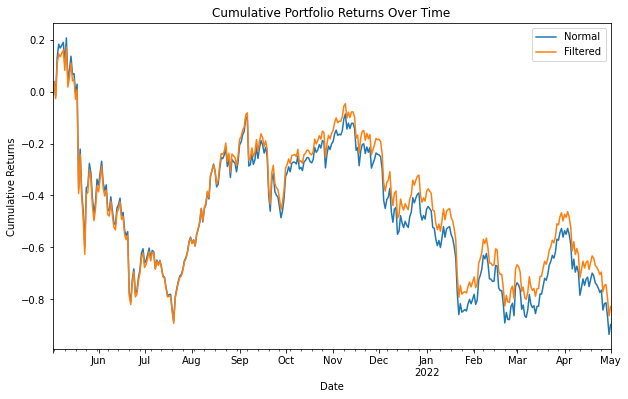

In [354]:

# Assuming 'weights_df' is your DataFrame with the weights
portfolio_norm_out = returns_test.mul(weights_norm_df['Weight'], axis=1)

portfolio_norm_out['Portfolio'] = portfolio_norm_out.sum(axis=1)

# Drop all columns except for 'Portfolio'
portfolio_norm_out = portfolio_norm_out[['Portfolio']]

# Plot 'Portfolio'
portfolio_norm_out.plot(figsize=(10, 6))
plt.title('Portfolio Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

# Calculate cumulative returns
portfolio_norm_out['Cumulative Returns'] = portfolio_norm_out['Portfolio'].cumsum()

# Plot cumulative returns
portfolio_norm_out['Cumulative Returns'].plot(figsize=(10, 6))
plt.title('Cumulative Portfolio Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()



# Assuming 'weights_df' is your DataFrame with the weights
portfolio_filtered_out = returns_test.mul(weights_filtered_df['Weight'], axis=1)

portfolio_filtered_out['Portfolio'] = portfolio_filtered_out.sum(axis=1)

# Drop all columns except for 'Portfolio'
portfolio_filtered_out = portfolio_filtered_out[['Portfolio']]

# Plot 'Portfolio'
portfolio_filtered_out.plot(figsize=(10, 6))
plt.title('Portfolio Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

# Calculate cumulative returns
portfolio_filtered_out['Cumulative Returns'] = portfolio_filtered_out['Portfolio'].cumsum()

# Plot cumulative returns
portfolio_filtered_out['Cumulative Returns'].plot(figsize=(10, 6))
plt.title('Cumulative Portfolio Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()

# plot portfolio_normal['Cumulative Returns'] and portfolio['Cumulative Returns'] on the same graph
portfolio_norm_out['Cumulative Returns'].plot(figsize=(10, 6))
portfolio_filtered_out['Cumulative Returns'].plot(figsize=(10, 6))
plt.title('Cumulative Portfolio Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(['Normal', 'Filtered'])
plt.show()

In [372]:
# Checking for similarity between the two principal components

np.corrcoef(eigen_filtered, eigen_normal)
cosine_similarity = np.dot(eigen_filtered, eigen_normal) / (np.linalg.norm(eigen_filtered) * np.linalg.norm(eigen_normal))
print(cosine_similarity)

0.9740473370917436


# 6. Benchmark comparison

*The filtered eigenportfolio shows a better financial performance compared to the original one, but it is also important to check for the results against other benchmarks used in the crypto market*

## 6.1. Bitcoin

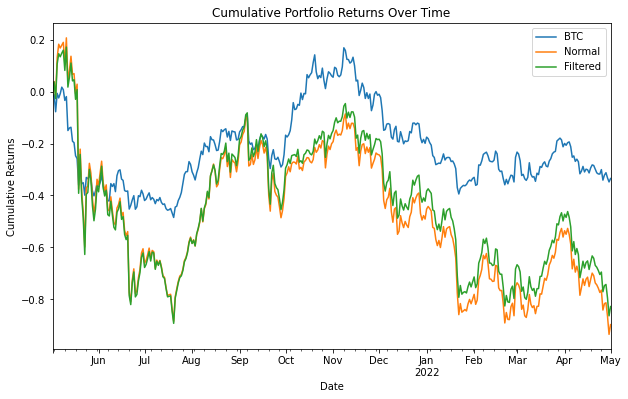

In [356]:
#btc_cumulative_return = (returns_test['BTC']).cumsum()
btc_cumulative_return = np.exp((returns_test['BTC']).cumsum()) - 1


# plot portfolio_normal['Cumulative Returns'] and portfolio['Cumulative Returns'] on the same graph
btc_cumulative_return.plot(figsize=(10, 6))
portfolio_norm_out['Cumulative Returns'].plot(figsize=(10, 6))
portfolio_filtered_out['Cumulative Returns'].plot(figsize=(10, 6))
plt.title('Cumulative Portfolio Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(['BTC', 'Normal', 'Filtered'])
plt.show()

## 6.2. CRIX

Index(['Royalton CRIX Crypto Index'], dtype='object')


<AxesSubplot:xlabel='Effective date '>

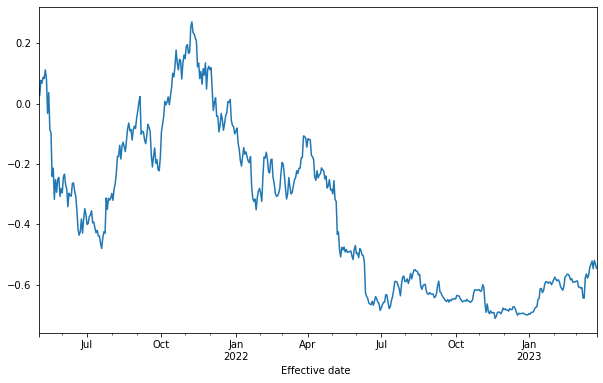

In [357]:
crix = pd.read_excel('PerformanceGraphExport.xls', sheet_name='Performance Graph', index_col= 'Effective date ')
print(crix.columns)
crix_returns = np.log(crix / crix.shift(1))
crix_returns = crix_returns.dropna()

crix_test = crix_returns[(crix_returns.index > pd.to_datetime("2021-04-30"))]
#crix_cum_ret= (crix_test['Royalton CRIX Crypto Index']).cumsum()
crix_cum_ret = np.exp(crix_test['Royalton CRIX Crypto Index'].cumsum()) - 1

crix_cum_ret.plot(figsize=(10, 6))

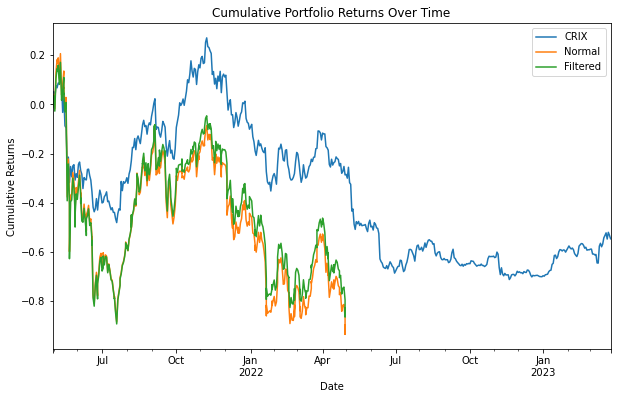

In [358]:
# plot portfolio_normal['Cumulative Returns'] and portfolio['Cumulative Returns'] on the same graph
crix_cum_ret.plot(figsize=(10, 6))
portfolio_norm_out['Cumulative Returns'].plot(figsize=(10, 6))
portfolio_filtered_out['Cumulative Returns'].plot(figsize=(10, 6))
plt.title('Cumulative Portfolio Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(['CRIX', 'Normal', 'Filtered'])
plt.show()

## 6.3. Equally weighted index

<AxesSubplot:xlabel='Date'>

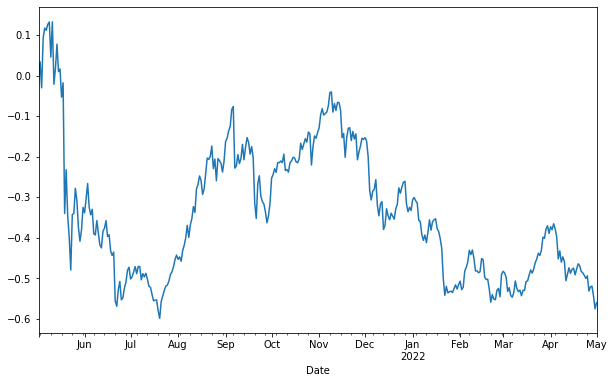

In [359]:
# Create a list of tickers from the correlation matrix
tickers = correlations.columns.tolist()

# Multiply the prices by equal weights (1/number of tickers)
eq_weights = returns_test.mul(1/len(tickers), axis=1)

# create a column "returns" that is the sum of all the rows
eq_weights['returns'] = eq_weights.sum(axis=1)

# only keep the "returns" column
eq_weights = eq_weights[['returns']]

cum_ret_eq = np.exp(eq_weights['returns'].cumsum()) - 1

cum_ret_eq.plot(figsize=(10, 6))


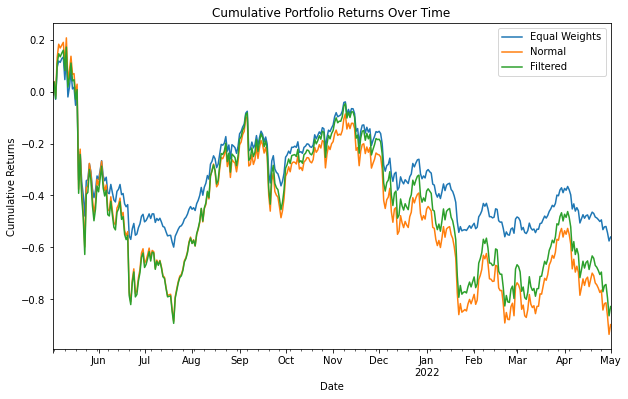

In [ ]:
cum_ret_eq.plot(figsize=(10, 6))
portfolio_norm_out['Cumulative Returns'].plot(figsize=(10, 6))
portfolio_filtered_out['Cumulative Returns'].plot(figsize=(10, 6))
plt.title('Cumulative Portfolio Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(['Equal Weights', 'Normal', 'Filtered'])
plt.show()

## 6.4. Overall index

*Here we combine the in sample and the out of sample performance of the two indices*

ticker      Portfolio  Cumulative Returns
Date                                     
2020-09-30   0.001724            0.001726
2020-10-01  -0.018419           -0.016556
2020-10-02  -0.030832           -0.046415
2020-10-03   0.001223           -0.045248
2020-10-04   0.012716           -0.033030
...               ...                 ...
2022-04-27   0.024616            1.742818
2022-04-28   0.003438            1.752264
2022-04-29  -0.051713            1.613555
2022-04-30  -0.069934            1.437022
2022-05-01   0.037569            1.530319

[565 rows x 2 columns]


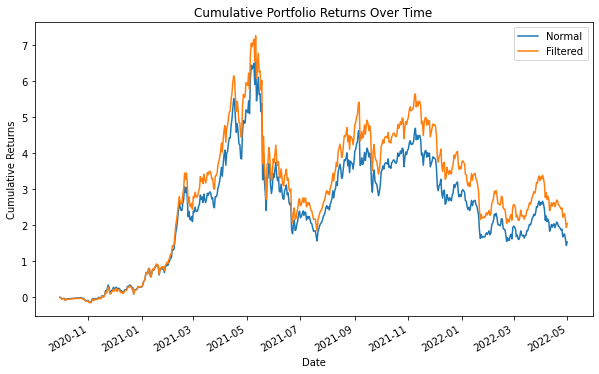

In [371]:
normal_index = pd.concat([portfolio_norm_in, portfolio_norm_out])
filtered_index = pd.concat([portfolio_filtered_in, portfolio_filtered_out])

normal_index['Cumulative Returns'] = np.exp(normal_index['Portfolio'].cumsum()) - 1
filtered_index['Cumulative Returns'] = np.exp(filtered_index['Portfolio'].cumsum()) - 1

print(normal_index)


normal_index['Cumulative Returns'].plot(figsize=(10, 6))
filtered_index['Cumulative Returns'].plot(figsize=(10, 6))
plt.title('Cumulative Portfolio Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(['Normal', 'Filtered'])
plt.show()